# SECTION 1: Setting Up

## 1A. Importing Libraries

In [123]:
# importing requried library

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
import numpy as np

## 1B: Importing Data

In [124]:
# Import db
db_path = 'data/bmarket.db'
connection = sqlite3.connect(db_path)

query = "SELECT * FROM bank_marketing"
raw_data = pd.read_sql_query(query, connection)
connection.close()

raw_data.head()


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [125]:
raw_data.shape

(41188, 12)

# SECTION 2: Data Cleaning

This section involves **data cleaning, imputation, and outlier removal** to prepare the dataset for further analysis and feature engineering.  

At the end of this section, the cleaned dataset **`data_clean`** will be used for EDA and feature engineering.

In [126]:
# Basic Summary of Columns
raw_data.describe(include='all')

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
count,41188.00000,41188,41188,41188,41188,41188,16399,37042,41188,41188.000000,41188.000000,41188
unique,NaN,77,12,4,8,3,3,3,4,NaN,NaN,2
top,NaN,150 years,admin.,married,university.degree,no,yes,no,Cell,NaN,NaN,no
freq,NaN,4197,10422,24928,12168,32588,8595,30532,13100,NaN,NaN,36548
mean,20594.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.051374,962.475454,NaN
std,11890.09578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.171345,186.910907,NaN
min,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-41.000000,0.000000,NaN
25%,10297.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,999.000000,NaN
50%,20594.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,999.000000,NaN
75%,30891.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,999.000000,NaN


In [127]:
data_clean = raw_data.copy()

In [128]:
# Convert 'Age' column in raw_data to integer by splitting the string
data_clean['Age'] = data_clean['Age'].str.split().str[0].astype(int)

# Define the quantiive columns
quantitative_cols = [
    "Age",
    "Campaign Calls",
    "Previous Contact Days"
]

# Create a dictionary to store counts of negative values and zeros
outlier_counts = {
    "Column": [],
    "Negative Values": [],
    "Zero Values": []
}

# Loop through each column and count negatives and zeros
for col in quantitative_cols:
    neg_count = (data_clean[col] < 0).sum()
    zero_count = (data_clean[col] == 0).sum()

    outlier_counts["Column"].append(col)
    outlier_counts["Negative Values"].append(neg_count)
    outlier_counts["Zero Values"].append(zero_count)

# Convert dictionary to DataFrame
outlier_counts_df = pd.DataFrame(outlier_counts)
print(outlier_counts_df)


                  Column  Negative Values  Zero Values
0                    Age                0            0
1         Campaign Calls             4153            0
2  Previous Contact Days                0           15


## 2A. Marking Rows / Columns for Removal

A cursory analysis of the dataset structure and missing value distribution led to marking the following columns / rows for removal. 

Rows (Quantitative Outliers)

- **Age**: `Large presence of clients with age of 150`  (Unlikely to be legitimate) -> Remove rows with clients of age 150

- **Campaign Calls**: `Prescence of negative values`  (Unlikely to be legitimate) -> Remove rows calls with negative values like -1, -32, -41

Columns:

- **Client ID**: `High Cardinality` (Not useful towards prediction) -> Drop column

In [129]:
# Remove rows where Age is 150
data_clean = data_clean[data_clean['Age'] != '150 years']

# Remove rows where Campaign Calls is a negative number
data_clean = data_clean[data_clean['Campaign Calls'] >= 0]

# Remove Client ID column
data_clean = data_clean.drop(columns=['Client ID'])

data_clean.shape


(37035, 11)

## 2B. Handling Missing Values

From prior analysis, missing values were found in:
- `Housing Loan` (60.2% missing) 
- `Personal Loan` (10.1% missing)

Since these are categorical, I imputed these missing values with "unknown", which is consistent with other columns such as "Credit Default" and "Education Level" that has "unknown" in the data as well.

In [130]:
# Impute "unknown" for missing values
data_clean['Housing Loan'] = data_clean['Housing Loan'].fillna('unknown')
data_clean['Personal Loan'] = data_clean['Personal Loan'].fillna('unknown')

data_clean.describe(include='all')


,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
count,37035.000000,37035,37035,37035,37035,37035,37035,37035,37035.000000,37035.000000,37035
unique,NaN,12,4,8,3,3,3,4,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,unknown,no,Cell,NaN,NaN,no
freq,NaN,9376,22393,10978,29269,22712,27428,11761,NaN,NaN,32811
mean,51.240745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.568462,962.830674,NaN
std,34.767327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.763739,186.034120,NaN
min,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,999.000000,NaN
50%,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,999.000000,NaN
75%,51.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,999.000000,NaN


## 2C. Feature Conversion  

1. `Contact Method:`
- Contact Method column contained 'Cell', 'cellular' and 'Telephone', 'telephone', I decided to standardize to 'Cell' as it is interchangable with cellular. I also standardized  to 'Telephone'

2. `Previous Contact Days:`
- Previous Contact Days column contains values such as 999, which indicates no previous contact. In order to handle this cleanly and to have meaningful order. I binned it into multiple categories such as 999 representing "no_prev_contact" and days <=5 representing "last_5_days"

3. `Campaign Calls:`
- Most values are small (1–5), but a few clients have been contacted 20+ times. To reduce cardinality, I bin the values into multiple categories

4. `Age:`
- To reduce the cardinality of the 'Age' column which has 76 unique values, I bin the ages into broader age groups




In [131]:
# Standardize 'Contact Method' values
data_clean['Contact Method'] = data_clean['Contact Method'].replace(
    {'cellular': 'Cell', 'Cell': 'Cell', 'telephone': 'Telephone', 'Telephone': 'Telephone'}
)

# Bin 'Previous Contact Days' into categories
def categorize_pdays(p):
    if p == 999:
        return "no_prev_contact"
    elif p <= 5:
        return "last_5_days"
    elif p <= 10:
        return "last_10_days"
    elif p <= 15:
        return "last_15_days"
    else:
        return "more_than_15_days"

data_clean['Previous Contact Days'] = data_clean['Previous Contact Days'].apply(categorize_pdays)

# Bin 'Campaign Calls' into categories
def bucket_campaign(x):
    if x == 1:
        return '1_call'
    elif x == 2:
        return '2_calls'
    elif 3 <= x <= 5:
        return '3-5_calls'
    elif 6 <= x <= 10:
        return '6-10_calls'
    else:
        return '10+_calls'

data_clean['Campaign Calls'] = data_clean['Campaign Calls'].apply(bucket_campaign)

# Bin 'Age' into categories
def bucket_age(x):
    if x < 30:
        return '20s'
    elif x < 40:
        return '30s'
    elif x < 50:
        return '40s'
    elif x < 60:
        return '50s'
    else:
        return '60s+'
    
data_clean['Age'] = data_clean['Age'].apply(bucket_age)

In [132]:
data_clean.describe(include='all')

,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
count,37035,37035,37035,37035,37035,37035,37035,37035,37035,37035,37035
unique,5,12,4,8,3,3,3,2,5,5,2
top,30s,admin.,married,university.degree,no,unknown,no,Cell,1_call,no_prev_contact,no
freq,13742,9376,22393,10978,29269,22712,27428,23518,15874,35686,32811


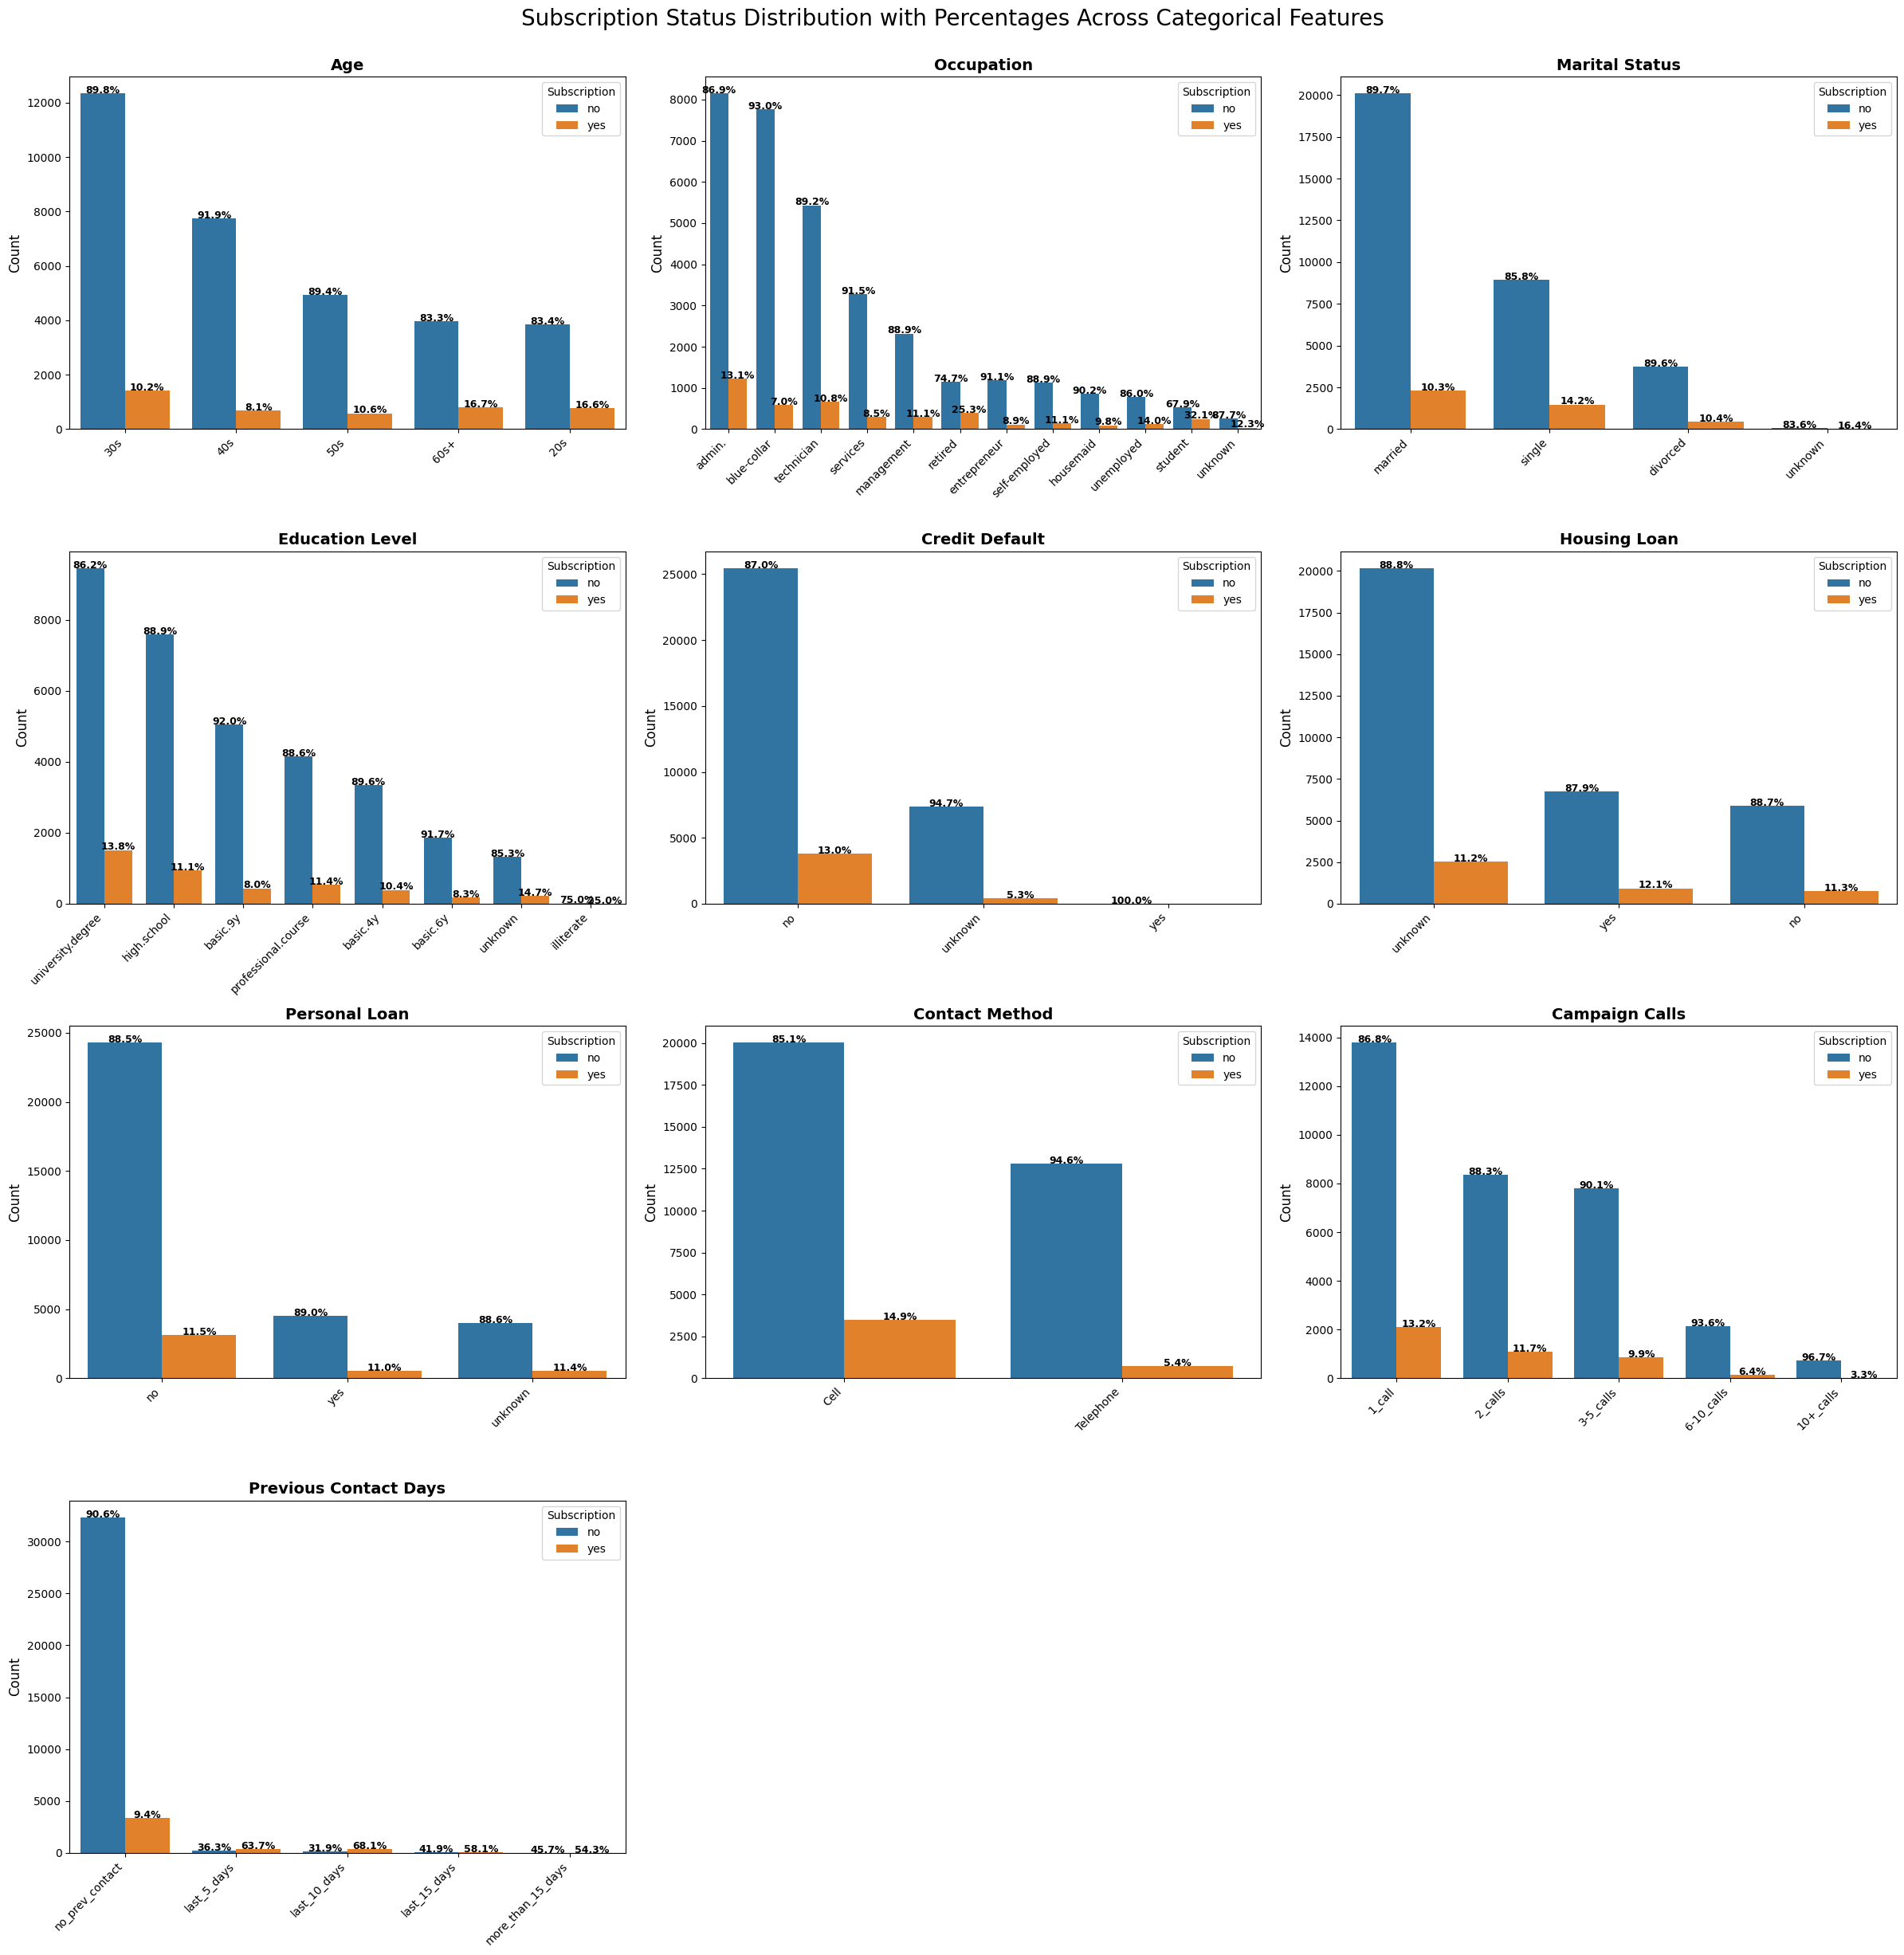

In [137]:
# Define your categorical features
cat_features = [
    'Age', 'Occupation', 'Marital Status', 'Education Level',
    'Credit Default', 'Housing Loan', 'Personal Loan',
    'Contact Method', 'Campaign Calls', 'Previous Contact Days'
]

# Create the subplot grid
fig, axes = plt.subplots(4, 3, figsize=(24, 24))
axes = axes.flatten()

for idx, feature in enumerate(cat_features):
    ax = axes[idx]
    
    # Get the order of categories based on frequency
    order = data_clean[feature].value_counts().index
    
    # Plot the counts first
    sns.countplot(
        data=data_clean,
        x=feature,
        hue='Subscription Status',
        ax=ax,
        order=order
    )
    
    # Calculate the percentages
    cross_tab = pd.crosstab(
        data_clean[feature], 
        data_clean['Subscription Status'],
        normalize='index'
    ) * 100
    
    # Ensure the crosstab has the same ordering as the plot
    cross_tab = cross_tab.reindex(order)
    
    # Add percentage labels
    # Get all the bars
    bars = ax.patches
    # Number of categories
    n_cats = len(order)
    # Number of categories times number of subscription statuses (yes/no = 2)
    # Half of the bars are for "No" and half for "Yes"
    
    # Loop through the bars and add text
    for i, bar in enumerate(bars):
        # Get the category index and the subscription status
        cat_idx = i % n_cats
        is_yes = i >= n_cats  # First n_cats bars are "No", rest are "Yes"
        
        # Get the category value
        cat_value = order[cat_idx]
        
        # Get the percentage
        if is_yes:
            if 'yes' in cross_tab.columns:
                pct = cross_tab.loc[cat_value, 'yes']
            else:
                pct = 0
        else:
            if 'no' in cross_tab.columns:
                pct = cross_tab.loc[cat_value, 'no']
            else:
                pct = 0
        
        # Add text only if the bar has height (avoids adding 0% labels)
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 5,
                f'{pct:.1f}%',
                ha='center',
                fontsize=9,
                fontweight='bold'
            )
    
    # Set titles and labels
    ax.set_title(feature, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Subscription', loc='upper right')

# Remove any unused subplots
for j in range(len(cat_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust x-axis labels
for ax in axes[:len(cat_features)]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.suptitle('Subscription Status Distribution with Percentages Across Categorical Features', 
             fontsize=20, y=1.02)
plt.show()

In [138]:
data_clean

,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,50s,technician,married,high.school,no,no,yes,Cell,1_call,no_prev_contact,no
1,50s,unknown,married,unknown,unknown,yes,no,Telephone,2_calls,no_prev_contact,no
2,30s,blue-collar,married,basic.9y,no,no,no,Cell,1_call,no_prev_contact,no
3,30s,admin.,married,high.school,no,no,no,Telephone,3-5_calls,no_prev_contact,no
4,20s,housemaid,married,high.school,no,unknown,no,Cell,2_calls,no_prev_contact,no
...,...,...,...,...,...,...,...,...,...,...,...
41183,50s,retired,married,professional.course,unknown,no,no,Telephone,2_calls,no_prev_contact,no
41184,30s,management,married,university.degree,no,no,no,Telephone,1_call,no_prev_contact,no
41185,30s,admin.,married,high.school,no,unknown,no,Cell,1_call,last_5_days,yes
41186,40s,management,married,university.degree,no,unknown,no,Telephone,2_calls,no_prev_contact,no


# SECTION 3: Insights & Conclusions

## 3A. Insights

After analyzing the dataset, here are some of the conclusions / insights made from the EDA based on the respective columns:


- **Age**: Highest Subscription Rate among individuals in their 20s and 60s+

- **Occupation**: Highest Subscription Rate among students and retired

- **Marital Status**: Highest Subscription Rate for Singles

- **Education Level**: Highest Subscription Rate for individuals with University degrees

- **Credit Default**: Highest Subscription Rate for individuals with no credit defaults. No Subscriptions for those with credit defaults

- **Housing Loan**: Subscription Rate is relatively consistent among individuals with or without housing loans 

- **Personal Loan**: Subscription Rate is relatively consistent among individuals with or without personal loans

- **Contact Method**: Highest Subscription Rate for indiviudals contacted via cellular mobile phones.

- **Campaign Calls**: Highest Subscription Rate for indiviudals called 1-5 times

- **Previous Contact Days**: Higher Subscription Rate for those that have been contacted before compared to those without contact